In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 2.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15297, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 15297 (delta 7), reused 7 (delta 1), pack-reused 15275
Receiving objects: 100% (15297/15297), 6.18 MiB | 9.19 MiB/s, done.
Resolving deltas: 100% (11118/11118), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 787.4 kB/s eta 0:00:00
  Pr

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [3]:
import os
import numpy as np
import cv2
from detectron2.utils.logger import setup_logger
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.model_zoo import get_config_file, get_checkpoint_url
setup_logger()

<Logger detectron2 (DEBUG)>

In [4]:
# Function to convert mask to Detectron2's polygon format
def mask_to_polygons(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = [contour.flatten().tolist() for contour in contours if len(contour.flatten()) > 4]
    return polygons

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Dataset loading function
def get_custom_dataset_dicts(dataset_dir, is_train=True):
    dataset_dicts = []
    for filename in os.listdir(os.path.join(dataset_dir, "image")):
        if filename.endswith(".jpg"):  # Assuming image files are JPG
            image_path = os.path.join(dataset_dir, "image", filename)
            mask_path = os.path.join(dataset_dir, "mask", filename)  # Adjust if needed

            height, width = cv2.imread(image_path).shape[:2]
            record = {"file_name": image_path, "image_id": filename, "height": height, "width": width}

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                continue

            polygons = mask_to_polygons(mask)

            # Get bounding box from mask
            x, y, w, h = cv2.boundingRect(mask)
            bbox = [x, y, x + w, y + h]  # 1-dimensional list for bbox

            objs = [{"segmentation": polygons, "bbox": bbox, "bbox_mode": BoxMode.XYXY_ABS, "category_id": 0}]
            record["annotations"] = objs
            dataset_dicts.append(record)

    print("Dataset length: ", len(dataset_dicts))
    return dataset_dicts


In [7]:
training_dataset_path = "/content/drive/MyDrive/DIP/training_dataset"
# Register the dataset
for d in ["train", "val"]:
    DatasetCatalog.register("my_dataset_" + d, lambda d=d: get_custom_dataset_dicts(training_dataset_path, is_train=(d == "train")))
    MetadataCatalog.get("my_dataset_" + d).set(thing_classes=["object"])

Dataset length:  60
BBox: [412, 370, 1023, 460]
Segmentation: [[980, 370, 979, 371, 933, 371, 932, 372, 886, 372, 885, 373, 839, 373, 838, 374, 791, 374, 790, 375, 744, 375, 743, 376, 697, 376, 696, 377, 650, 377, 649, 378, 603, 378, 602, 379, 556, 379, 555, 380, 509, 380, 508, 381, 461, 381, 460, 382, 414, 382, 413, 383, 412, 383, 412, 384, 415, 387, 415, 388, 417, 390, 417, 391, 420, 394, 420, 395, 423, 398, 423, 399, 426, 402, 425, 403, 424, 403, 423, 404, 423, 406, 422, 407, 420, 407, 420, 408, 421, 408, 422, 409, 423, 409, 424, 410, 425, 410, 426, 411, 427, 411, 428, 412, 429, 412, 430, 413, 461, 413, 462, 414, 497, 414, 498, 415, 534, 415, 535, 416, 570, 416, 571, 417, 606, 417, 607, 418, 624, 418, 625, 419, 640, 419, 641, 420, 656, 420, 657, 421, 672, 421, 673, 422, 685, 422, 686, 423, 697, 423, 698, 424, 712, 424, 713, 425, 718, 425, 719, 426, 723, 426, 724, 427, 728, 427, 729, 428, 733, 428, 734, 429, 737, 429, 738, 430, 741, 430, 742, 431, 745, 431, 746, 432, 749, 432, 750, 4

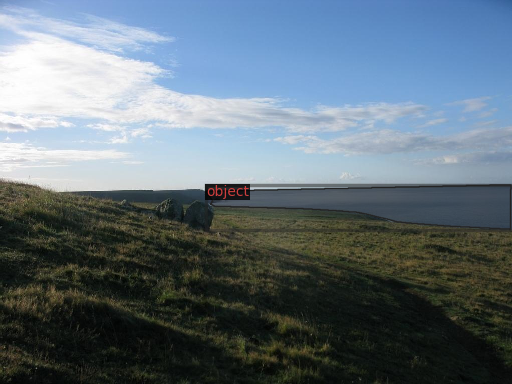

In [8]:
# Visualize Annotations

import random
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from google.colab.patches import cv2_imshow

training_dataset_path = "/content/drive/MyDrive/DIP/training_dataset"
dataset_dicts = get_custom_dataset_dicts(training_dataset_path, is_train=False)

for d in random.sample(dataset_dicts, 1):  # Visualize 1 random images
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("my_dataset_val"), scale=0.5)

    # Debugging: Print bbox and other annotation details
    for obj in d["annotations"]:
        print("BBox:", obj["bbox"])
        print("Segmentation:", obj["segmentation"])
        print("BBox type and shape:", type(obj["bbox"]), np.asarray(obj["bbox"]).shape)

    # Try drawing only the boxes
    out = visualizer.draw_dataset_dict(d)
    # cv2.imwrite(f'val_image_{d["file_name"]}.jpg', out.get_image()[:, :, ::-1])
    cv2_imshow(out.get_image()[:, :, ::-1])
    # cv2.imshow('Validation Image', vis.get_image()[:, :, ::-1])
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()




In [9]:
# Configuration
cfg = get_cfg()
cfg.merge_from_file(get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))  # Default configuration
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Default pretrained weights
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.002
cfg.SOLVER.MAX_ITER = 1000   # Adjust according to your dataset size
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Number of classes
cfg.SOLVER.ITER_DISPLAY = 1  # Display metrics every iteration
cfg.SOLVER.CHECKPOINT_PERIOD = 1000  # Save model every 1000 iterations

In [10]:
import torch
torch.cuda.is_available()

True

In [11]:
cfg.MODEL.DEVICE='cuda'

In [12]:
cfg.OUTPUT_DIR = "/content/drive/MyDrive/DIP/output"

In [13]:
# Training
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Save the model
model_path = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

[01/05 09:29:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 174MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[01/05 09:29:11 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/05 09:29:26 d2.utils.events]:  eta: 0:07:18  iter: 19  total_loss: 1.345  loss_cls: 0.5101  loss_box_reg: 0.03869  loss_mask: 0.6918  loss_rpn_cls: 0.04668  loss_rpn_loc: 0.02007    time: 0.4758  last_time: 0.5169  data_time: 0.0290  last_data_time: 0.0071   lr: 3.9962e-05  max_mem: 2455M
[01/05 09:29:38 d2.utils.events]:  eta: 0:07:01  iter: 39  total_loss: 1.006  loss_cls: 0.2022  loss_box_reg: 0.04329  loss_mask: 0.6503  loss_rpn_cls: 0.04128  loss_rpn_loc: 0.01603    time: 0.4510  last_time: 0.3972  data_time: 0.0087  last_data_time: 0.0058   lr: 7.9922e-05  max_mem: 2455M
[01/05 09:29:48 d2.utils.events]:  eta: 0:07:01  iter: 59  total_loss: 0.8257  loss_cls: 0.105  loss_box_reg: 0.058  loss_mask: 0.6066  loss_rpn_cls: 0.02793  loss_rpn_loc: 0.01411    time: 0.4608  last_time: 0.4031  data_time: 0.0160  last_data_time: 0.0069   lr: 0.00011988  max_mem: 2576M
[01/05 09:29:56 d2.utils.events]:  eta: 0:06:49  iter: 79  total_loss: 0.8093  loss_cls: 0.08588  loss_box_reg: 0.0691  

In [14]:
# Configure the Model for Evaluation
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Path to the model weights
cfg.DATASETS.TEST = ("my_dataset_val",)  # Validation dataset
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05  # Set a threshold for this model

# Import Evaluation Modules
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Perform Evaluation
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
inference_on_dataset(trainer.model, val_loader, evaluator)



[01/05 09:37:45 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [01/05 09:37:45 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[01/05 09:37:45 d2.evaluation.coco_evaluation]: Trying to convert 'my_dataset_val' to COCO format ...
WARNING [01/05 09:37:45 d2.data.datasets.coco]: Using previously cached COCO format annotations at '/content/drive/MyDrive/DIP/output/my_dataset_val_coco_format.json'. You need to clear the cache file if your dataset has been modified.
Dataset length:  60
[01/05 09:37:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/05 09:37:47 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/05 09:37:47 d2.data.common]: Serializing 60 elements to by

OrderedDict([('bbox',
              {'AP': 96.48238678129188,
               'AP50': 100.0,
               'AP75': 100.0,
               'APs': nan,
               'APm': 89.99999999999999,
               'APl': 96.57185697765546}),
             ('segm',
              {'AP': 91.0143726583146,
               'AP50': 100.0,
               'AP75': 100.0,
               'APs': nan,
               'APm': 80.0,
               'APl': 91.16992921448367})])

Dataset length:  60
[01/05 10:03:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/DIP/output/model_final.pth ...



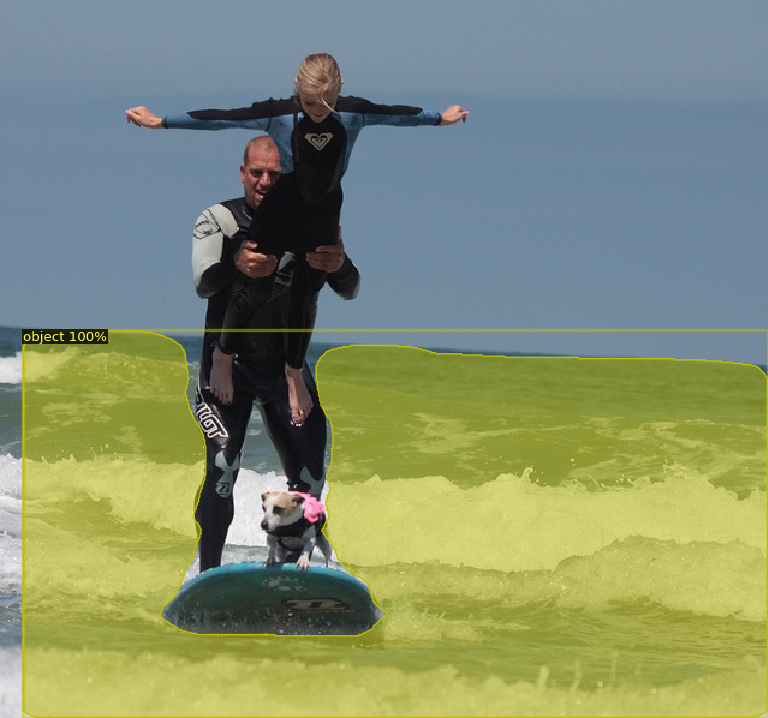

In [18]:
import random
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultPredictor
from google.colab.patches import cv2_imshow

# Load the validation dataset
val_dataset_dicts = DatasetCatalog.get(cfg.DATASETS.TEST[0])
val_metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])

# Randomly choose one image from the validation dataset
d = random.choice(val_dataset_dicts)

# Read the image
image = cv2.imread(d["file_name"])

# Create a predictor and run inference
predictor = DefaultPredictor(cfg)
outputs = predictor(image)

# Visualize the prediction results
v = Visualizer(image[:, :, ::-1], metadata=val_metadata, scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

print()

# Display or save the result
cv2_imshow(out.get_image()[:, :, ::-1])
# cv2.waitKey(0)
# cv2.destroyAllWindows()
